In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture

from tools import *
from plot import plot_two_figures, plot_each_labels
from preprocessing import RX_anomaly_detector

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
# Reshaping the HSI as a 2D matrix
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1]))
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1]))
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
print("Number of labels Indiana: {}".format(n_cluster_indiana))
print("Number of labels Salinas: {}".format(n_cluster_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


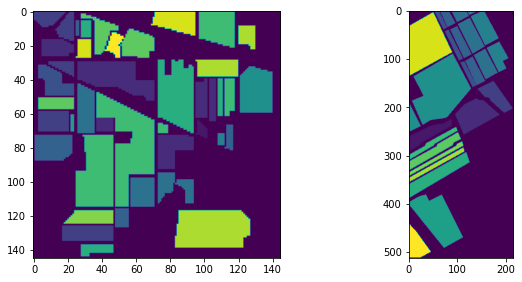

In [8]:
plot_two_figures(indiana_labels, salinas_labels)

 ## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [9]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [10]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 69
Number of components Salinas: 6


After retrieving the optimal number of components for each image, we need to compute a second PCA for each image to extract their features.

In [11]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [12]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (21025, 69)
Salinas reduced data shape: (111104, 6)


## RX anomaly detector

The Reed-Xiaoli Detector (RXD) algorithm is used to detect anomalies in hyperspectral imaging. It calculates a distance between the data sample with the background to determine anomalies.

In [13]:
X_indiana_reduced_img = X_indiana_reduced.reshape((indiana_img.shape[0], indiana_img.shape[1], X_indiana_reduced.shape[1]))
X_salinas_reduced_img = X_salinas_reduced.reshape((salinas_img.shape[0], salinas_img.shape[1], X_salinas_reduced.shape[1]))

In [14]:
indiana_anomalies = RX_anomaly_detector(X_indiana_reduced_img)
salinas_anomalies = RX_anomaly_detector(X_salinas_reduced_img)

In [15]:
outlier_indiana_pos = np.argwhere(indiana_anomalies == True).tolist()
outlier_salinas_pos = np.argwhere(salinas_anomalies == True).tolist()

In [16]:
X_salinas_no_outlier, X_salinas_outlier_positions = copy_without_outlier(X_salinas_reduced_img, outlier_salinas_pos)
X_indiana_no_outlier, X_indiana_outlier_positions = copy_without_outlier(X_indiana_reduced_img, outlier_indiana_pos)

# Gaussian Mixture

A gaussian mixture model is used for unsupervised learning. It is a probalistic model that represents normally distributed subpopulations within an overall population.

## Salinas image with outliers

In [17]:
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [18]:
salinas_model.fit(X_salinas_reduced)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [19]:
salinas_preds = salinas_model.predict(X_salinas_reduced)
salinas_preds = salinas_preds.reshape((salinas_img.shape[0], salinas_img.shape[1]))

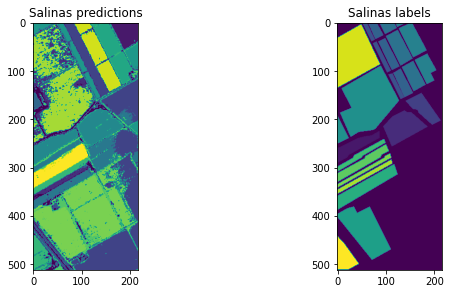

In [20]:
plot_two_figures(salinas_preds, salinas_labels, 'Salinas predictions', 'Salinas labels')

We can see that this model manages to classify some parts of the image but we can't get much information from it because the unclassified data has not been removed.

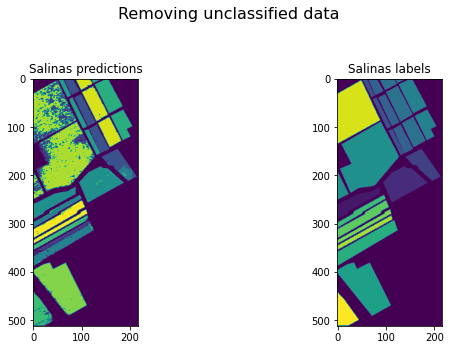

In [21]:
salinas_preds_corrected = remove_unclassified(salinas_preds, salinas_labels)
plot_two_figures(salinas_preds_corrected, salinas_labels, 'Salinas predictions', 'Salinas labels', suptitle='Removing unclassified data')

Now, we can see that this model is effective in distinguishing the different classes on the salinas image. Apart from the two parts at the top left, the parts do not have a lot of noise. The current objective is to verify that each class is well recognized. We will sort our prediction data and match the most present class to the one that is most preponderant in the ground truth.

In [22]:
salinas_labels_cpy, salinas_final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

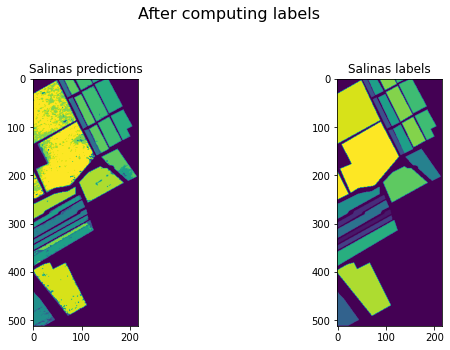

In [23]:
plot_two_figures(salinas_final_preds, salinas_labels_cpy, 'Salinas predictions', 'Salinas labels', suptitle='After computing labels')

It seems that this model is effective, most labels are well recognized when we look at the whole image.

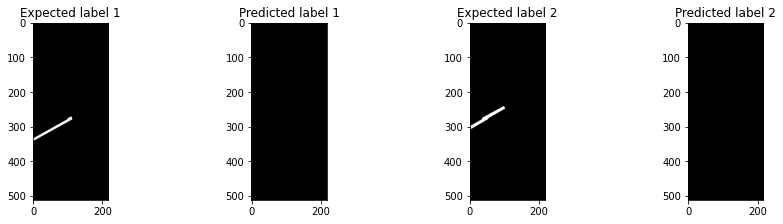

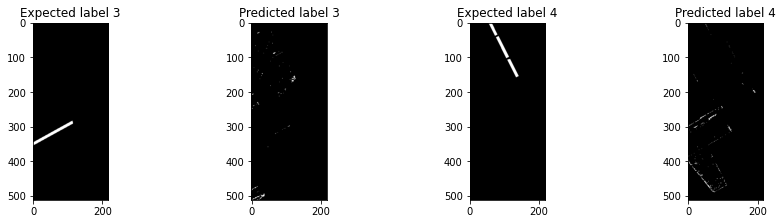

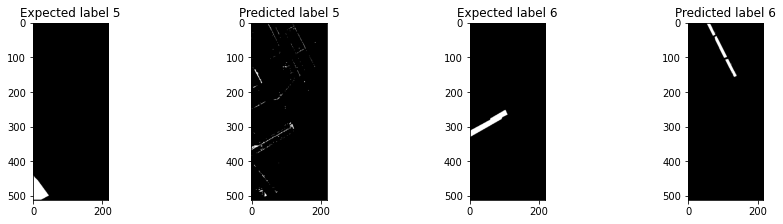

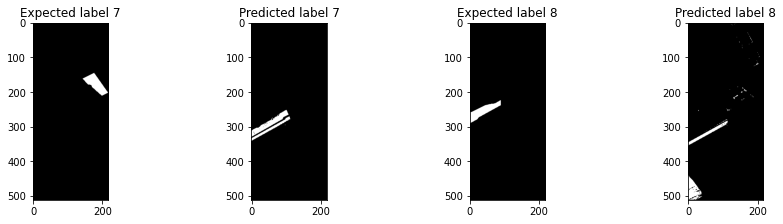

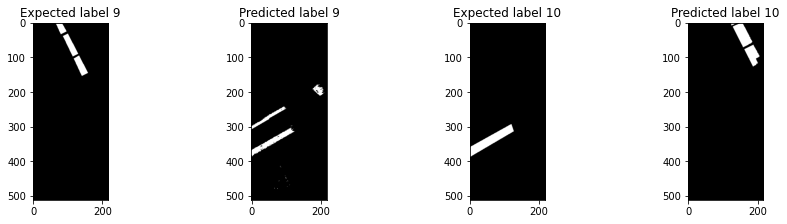

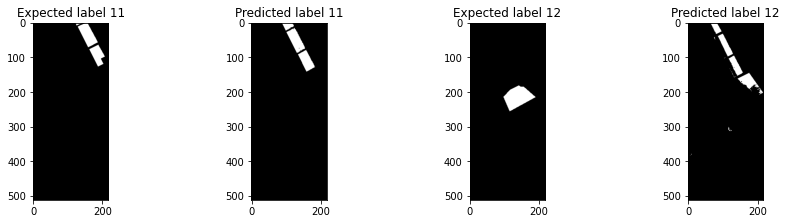

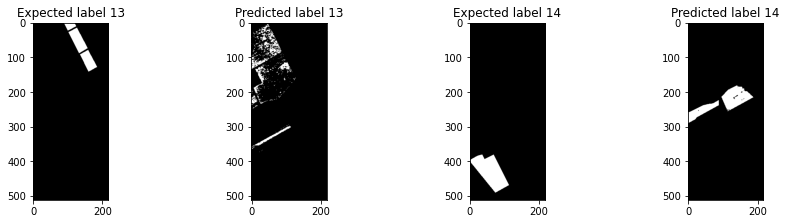

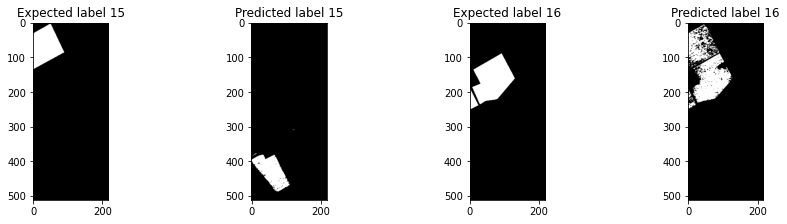

In [24]:
plot_each_labels(salinas_labels_cpy, salinas_final_preds, n_cluster_salinas, figsize=(15, 15), cmap='gray')

In [25]:
for i in range(1, n_cluster_salinas + 1):
    print('label {:''2d}: expected {:''5d} - predicted {:''5d}'.format(i, salinas_labels_cpy[salinas_labels_cpy == i].size, salinas_final_preds[salinas_final_preds == i].size))

label  1: expected   916 - predicted     0
label  2: expected  1068 - predicted     0
label  3: expected  1070 - predicted   361
label  4: expected  1394 - predicted   681
label  5: expected  1807 - predicted  1137
label  6: expected  1927 - predicted  1372
label  7: expected  1976 - predicted  2699
label  8: expected  2009 - predicted  2819
label  9: expected  2678 - predicted  3466
label 10: expected  3278 - predicted  3516
label 11: expected  3579 - predicted  3846
label 12: expected  3726 - predicted  4096
label 13: expected  3959 - predicted  5198
label 14: expected  6203 - predicted  5618
label 15: expected  7268 - predicted  5809
label 16: expected 11271 - predicted 13511


We can look at each class in detail. We can notice that the first four labels are not well recognized, but the others are sufficiently recognized. Obviously, our method to match each label is not the best since some classes contain a fairly close number of samples.

As an unsupervised model, the Gaussian mixture is the best model we have tested. Although two classes are not recognized, 

In [26]:
# Save predictions
np.save('../data/predictions/salinas_preds_gmm_with_outliers.npy', salinas_final_preds)

## Salinas without outliers

We will perform the same operations on the data without outliers.

In [27]:
salinas_model = GaussianMixture(n_components=n_cluster_salinas, verbose=1)

In [28]:
salinas_model.fit(X_salinas_no_outlier)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [29]:
salinas_preds = salinas_model.predict(X_salinas_no_outlier)

In [30]:
salinas_preds_outliers = rebuild_data_with_outliers(salinas_preds, X_salinas_outlier_positions, outlier_salinas_pos, (salinas_img.shape[0], salinas_img.shape[1]))

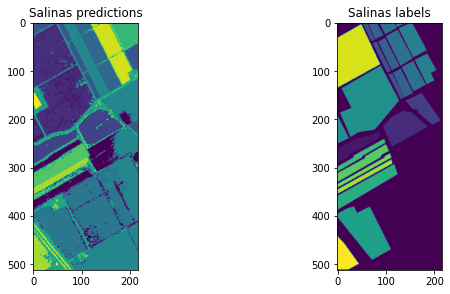

In [31]:
plot_two_figures(salinas_preds_outliers, salinas_labels, 'Salinas predictions', 'Salinas labels')

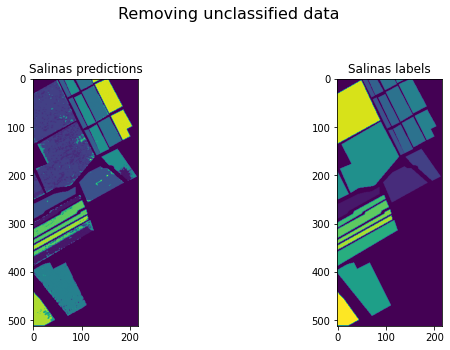

In [32]:
salinas_preds_corrected = remove_unclassified(salinas_preds_outliers, salinas_labels)
plot_two_figures(salinas_preds_corrected, salinas_labels, 'Salinas predictions', 'Salinas labels', suptitle='Removing unclassified data')

In [33]:
salinas_labels_cpy, salinas_final_preds = compute_labels_correspondence(salinas_labels, salinas_preds_corrected, n_cluster_salinas)

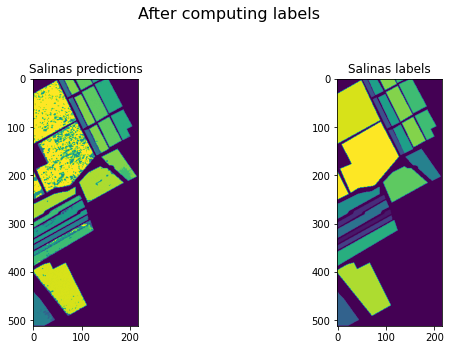

In [34]:
plot_two_figures(salinas_final_preds, salinas_labels_cpy, 'Salinas predictions', 'Salinas labels', suptitle='After computing labels')

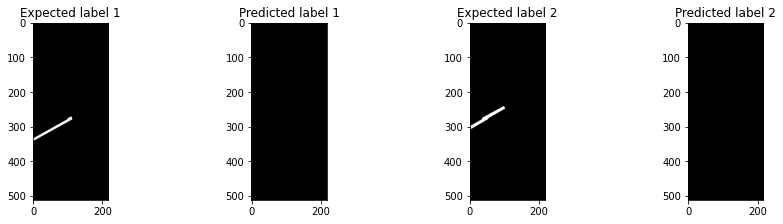

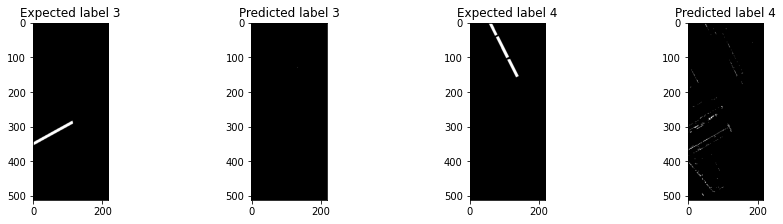

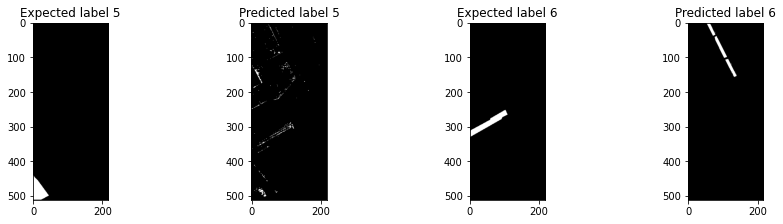

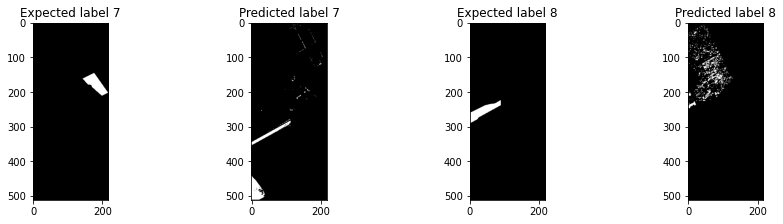

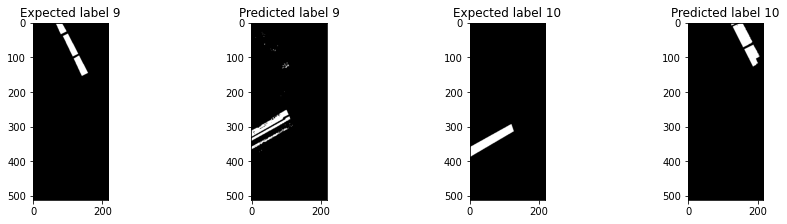

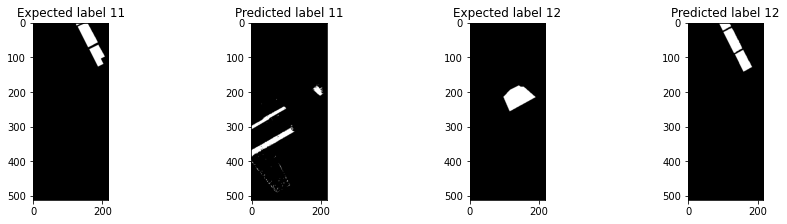

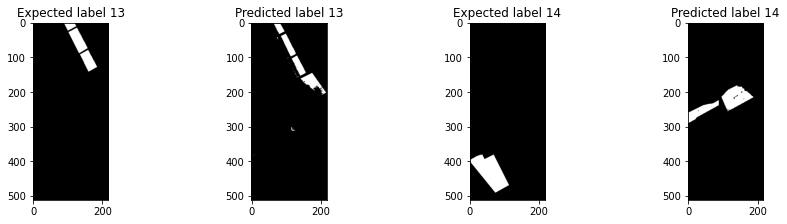

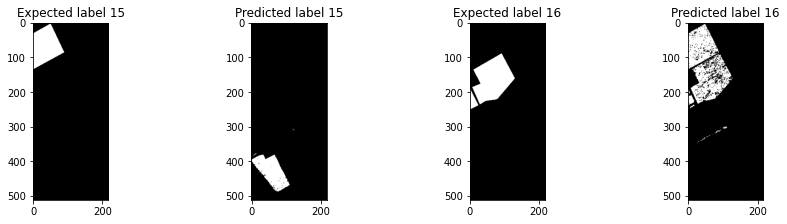

In [35]:
plot_each_labels(salinas_labels_cpy, salinas_final_preds, n_cluster_salinas, figsize=(15, 15), cmap='gray')

In [36]:
for i in range(1, n_cluster_salinas + 1):
    print('label {:''2d}: expected {:''5d} - predicted {:''5d}'.format(i, salinas_labels_cpy[salinas_labels_cpy == i].size, salinas_final_preds[salinas_final_preds == i].size))

label  1: expected   916 - predicted     0
label  2: expected  1068 - predicted     0
label  3: expected  1070 - predicted     1
label  4: expected  1394 - predicted   704
label  5: expected  1807 - predicted  1083
label  6: expected  1927 - predicted  1372
label  7: expected  1976 - predicted  2939
label  8: expected  2009 - predicted  3226
label  9: expected  2678 - predicted  3336
label 10: expected  3278 - predicted  3507
label 11: expected  3579 - predicted  3646
label 12: expected  3726 - predicted  3888
label 13: expected  3959 - predicted  4219
label 14: expected  6203 - predicted  5636
label 15: expected  7268 - predicted  5855
label 16: expected 11271 - predicted 14717


As we can see, the model is able to recognize one more class, but it seems that there are no improvements.

In [37]:
# Save predictions
np.save('../data/predictions/salinas_preds_gmm_without_outliers.npy', salinas_final_preds)

## Indiana with outliers

We will perform the same operations on indiana image.

In [38]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)

In [39]:
indiana_model.fit(X_indiana_reduced)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [40]:
indiana_preds = indiana_model.predict(X_indiana_reduced)
indiana_preds = indiana_preds.reshape((indiana_img.shape[0], indiana_img.shape[1]))

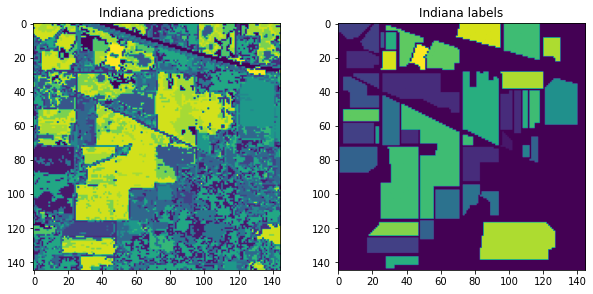

In [41]:
plot_two_figures(indiana_preds, indiana_labels, 'Indiana predictions', 'Indiana labels')

Before removing unclassified data, it is impossible to process the image of the predictions. It is too difficult to recognize some labels.

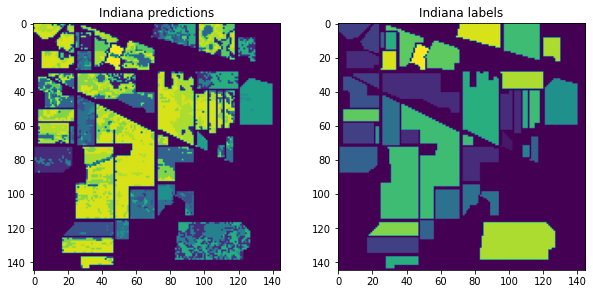

In [42]:
indiana_preds_corrected = remove_unclassified(indiana_preds, indiana_labels)
plot_two_figures(indiana_preds_corrected, indiana_labels, 'Indiana predictions', 'Indiana labels')

We can notice that the model is not effective on this image. There is a lot of noise on every block of the image.

In [43]:
indiana_labels_cpy, indiana_final_preds = compute_labels_correspondence(indiana_labels, indiana_preds_corrected, n_cluster_indiana)

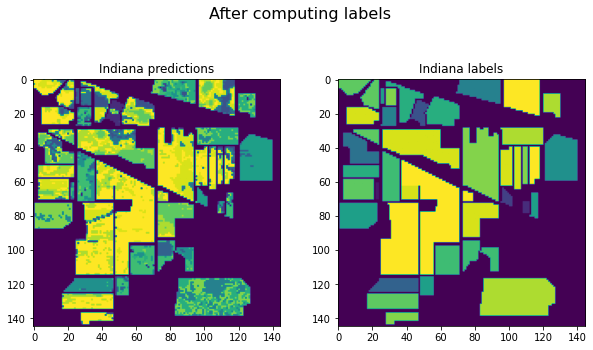

In [44]:
plot_two_figures(indiana_final_preds, indiana_labels_cpy, 'Indiana predictions', 'Indiana labels', suptitle='After computing labels')

In [45]:
for i in range(1, n_cluster_indiana + 1):
    print('label {:''2d}: expected {:''5d} - predicted {:''5d}'.format(i, indiana_labels_cpy[indiana_labels_cpy == i].size, indiana_final_preds[indiana_final_preds == i].size))

label  1: expected    20 - predicted    27
label  2: expected    28 - predicted    82
label  3: expected    46 - predicted   180
label  4: expected    93 - predicted   244
label  5: expected   205 - predicted   259
label  6: expected   237 - predicted   316
label  7: expected   386 - predicted   357
label  8: expected   478 - predicted   416
label  9: expected   483 - predicted   534
label 10: expected   593 - predicted   646
label 11: expected   730 - predicted   653
label 12: expected   830 - predicted   655
label 13: expected   972 - predicted   798
label 14: expected  1265 - predicted  1011
label 15: expected  1428 - predicted  1133
label 16: expected  2455 - predicted  2938


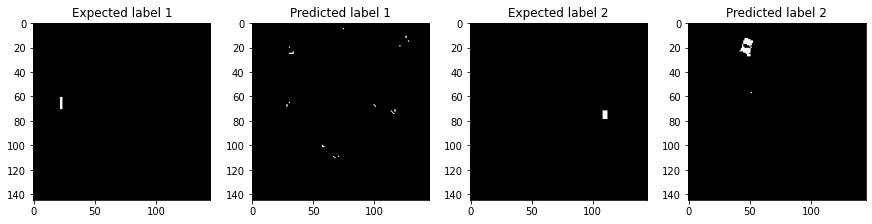

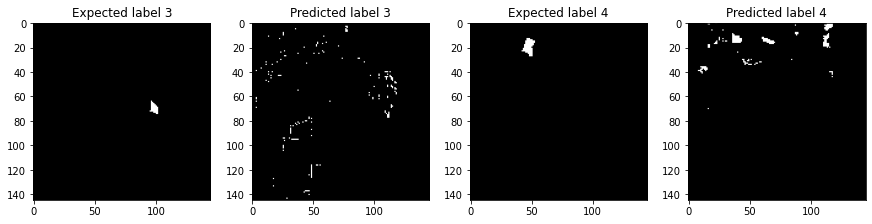

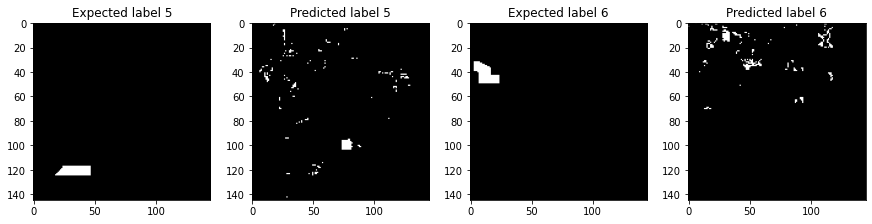

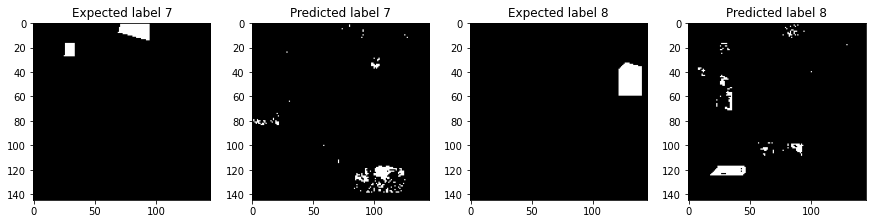

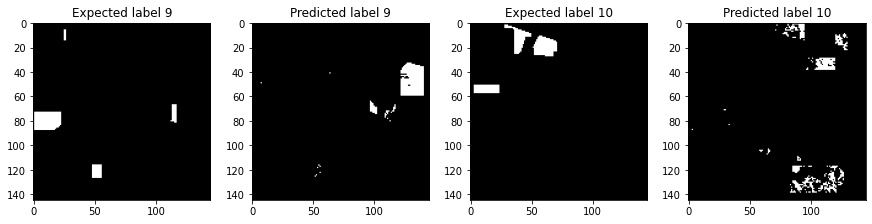

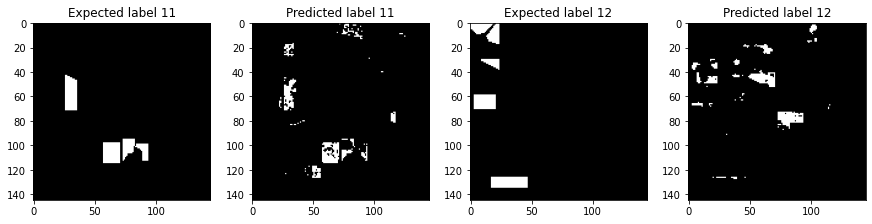

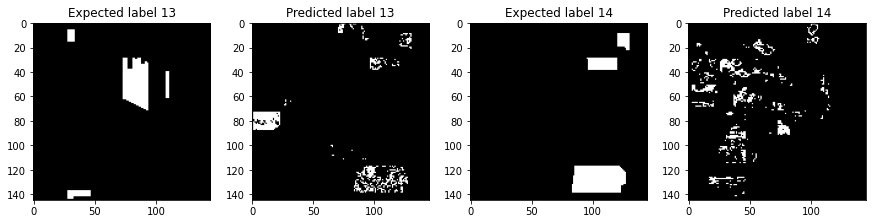

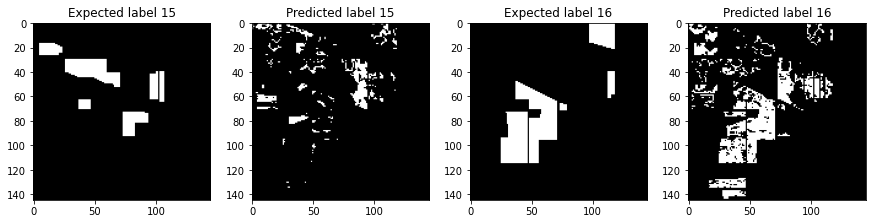

In [46]:
plot_each_labels(indiana_labels_cpy, indiana_final_preds, n_cluster_indiana, figsize=(15, 15), cmap='gray')

As we can see, it is difficult for the model to distinguish each label.

In [47]:
# Save predictions
np.save('../data/predictions/indiana_preds_gmm_with_outliers.npy', indiana_final_preds)

## Indiana without outliers

We will perform the same operations on indiana image without outliers.

In [48]:
indiana_model = GaussianMixture(n_components=n_cluster_indiana, verbose=1)

In [49]:
indiana_model.fit(X_indiana_no_outlier)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(n_components=16, verbose=1)

In [50]:
indiana_preds = indiana_model.predict(X_indiana_no_outlier)

In [51]:
indiana_preds_outliers = rebuild_data_with_outliers(indiana_preds, X_indiana_outlier_positions, outlier_indiana_pos, (indiana_img.shape[0], indiana_img.shape[1]))

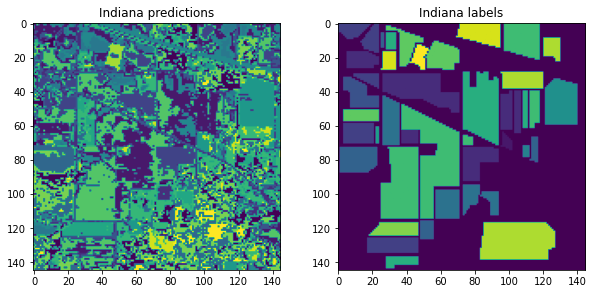

In [52]:
plot_two_figures(indiana_preds_outliers, indiana_labels, 'Indiana predictions', 'Indiana labels')

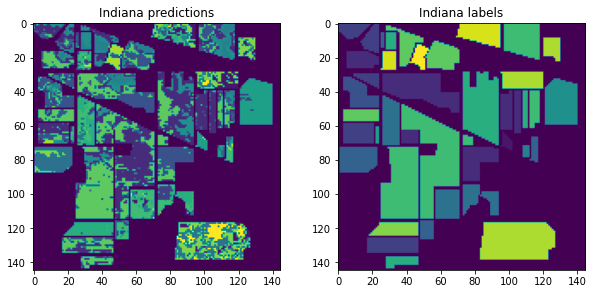

In [53]:
indiana_preds_corrected = remove_unclassified(indiana_preds_outliers, indiana_labels)
plot_two_figures(indiana_preds_corrected, indiana_labels, 'Indiana predictions', 'Indiana labels')

In [54]:
indiana_labels_cpy, indiana_final_preds = compute_labels_correspondence(indiana_labels, indiana_preds_corrected, n_cluster_indiana)

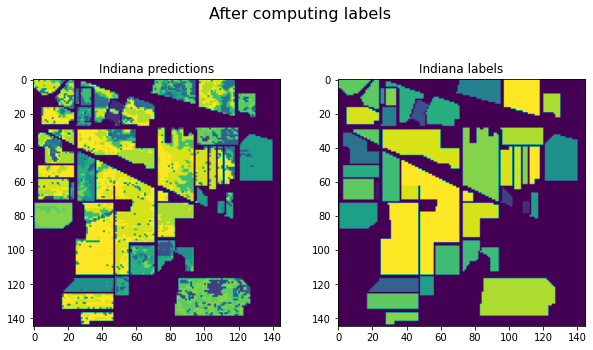

In [55]:
plot_two_figures(indiana_final_preds, indiana_labels_cpy, 'Indiana predictions', 'Indiana labels', suptitle='After computing labels')

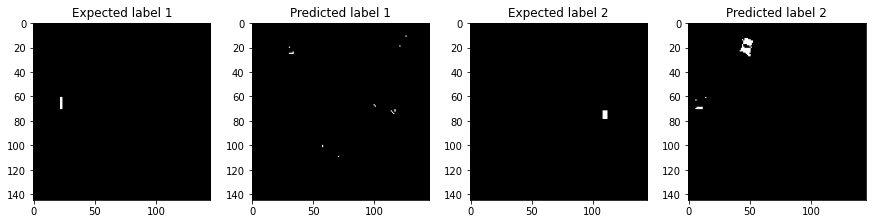

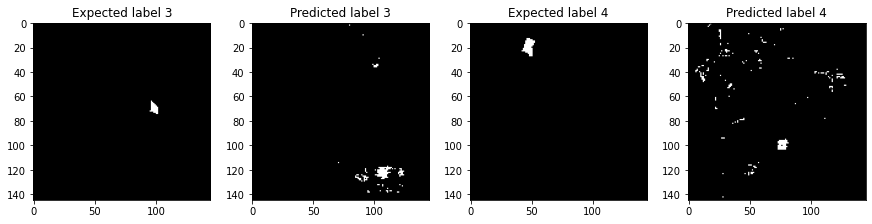

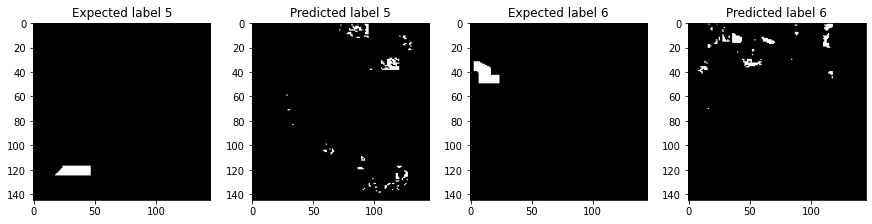

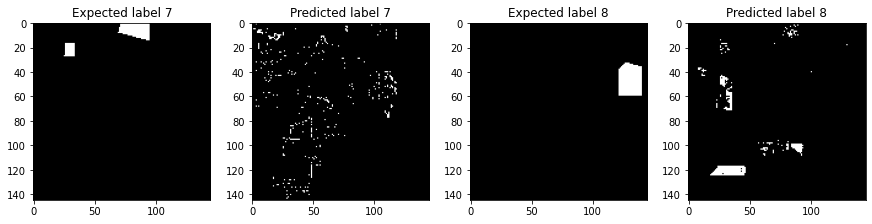

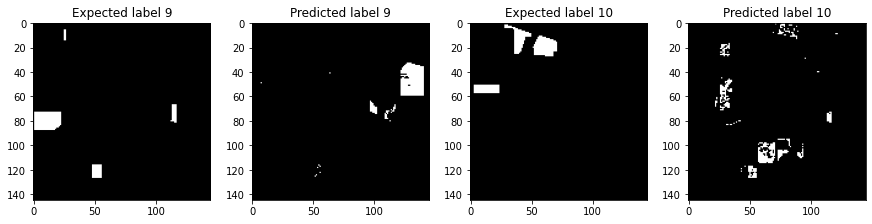

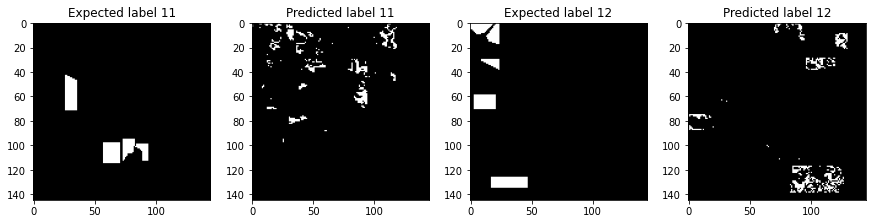

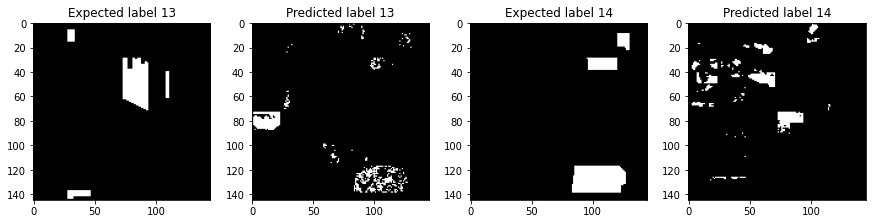

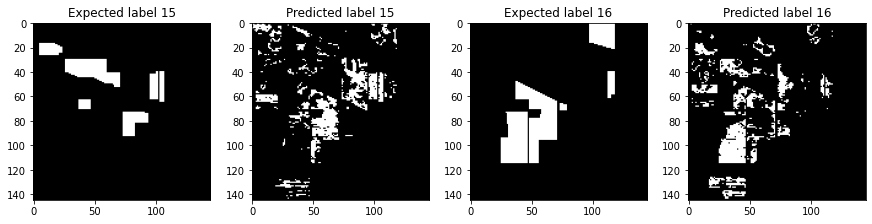

In [56]:
plot_each_labels(indiana_labels_cpy, indiana_final_preds, n_cluster_indiana, figsize=(15, 15), cmap='gray')

Gaussian Mixture is not better on Indiana image without outliers. It is diffcult to recognize a label.

In [57]:
# Save predictions
np.save('../data/predictions/indiana_preds_gmm_without_outliers.npy', indiana_final_preds)